In [473]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [474]:
import os
datasets = []
for filename in os.listdir("datasets"):
   with open(os.path.join("datasets/", filename), 'r', encoding='utf-8') as f:
       df = pd.read_json(f, encoding='utf-8')
       df['industry'] = [filename for _ in range(df.shape[0])]
       datasets.append(df)


In [475]:
datasets[0].head()

,id,premium,name,department,has_test,response_letter_required,salary,address,employer,snippet,...,working_days,working_time_intervals,working_time_modes,accept_temporary,professional_roles,accept_incomplete_resumes,experience,employment,is_adv_vacancy,industry
0,98502179,False,Офисный водитель с функциями персонального вод...,None,False,False,"{'from': None, 'to': 100000, 'currency': 'RUR'...","{'city': 'Москва', 'street': 'Западный админис...",{'trusted': True},{'requirement': 'СТРОГО Соблюдение конфиденциа...,...,[],[],[],False,"[{'id': '21', 'name': 'Водитель'}]",True,"{'id': 'between3And6', 'name': 'От 3 до 6 лет'}","{'id': 'full', 'name': 'Полная занятость'}",False,"industry(Перевозки, логистика, склад, ВЭД).json"
1,98303074,True,Работник склада,None,False,False,"{'from': 85000, 'to': None, 'currency': 'RUR',...","{'city': 'деревня Ближние Прудищи', 'street': ...",{'trusted': True},{'requirement': 'Опыт работы на складах будет ...,...,[],[],[],False,"[{'id': '52', 'name': 'Кладовщик'}]",True,"{'id': 'noExperience', 'name': 'Нет опыта'}","{'id': 'full', 'name': 'Полная занятость'}",False,"industry(Перевозки, логистика, склад, ВЭД).json"
2,98448824,False,Ведущий специалист по кадровому делопроизводству,None,False,False,"{'from': 155000, 'to': None, 'currency': 'RUR'...","{'city': 'Москва', 'street': '1-й Павловский п...",{'trusted': True},{'requirement': 'Высшее образование. Опыт рабо...,...,[],[],[],False,"[{'id': '117', 'name': 'Специалист по кадрам'}]",False,"{'id': 'between3And6', 'name': 'От 3 до 6 лет'}","{'id': 'full', 'name': 'Полная занятость'}",False,"industry(Перевозки, логистика, склад, ВЭД).json"
3,95565011,False,Специалист по работе с пассажирами,None,False,False,"{'from': None, 'to': 120000, 'currency': 'RUR'...",None,{'trusted': True},{'requirement': 'Образование: высшее или средн...,...,[],[],[],False,"[{'id': '39', 'name': 'Диспетчер'}]",True,"{'id': 'noExperience', 'name': 'Нет опыта'}","{'id': 'full', 'name': 'Полная занятость'}",False,"industry(Перевозки, логистика, склад, ВЭД).json"
4,98081735,False,Машинист электропоезда,None,False,False,"{'from': 147000, 'to': None, 'currency': 'RUR'...","{'city': 'Москва', 'street': 'Замоскворецкая л...",{'trusted': True},{'requirement': 'Образование не ниже среднего ...,...,[],[],[],False,"[{'id': '63', 'name': 'Машинист'}]",True,"{'id': 'between1And3', 'name': 'От 1 года до 3...","{'id': 'full', 'name': 'Полная занятость'}",False,"industry(Перевозки, логистика, склад, ВЭД).json"


Теперь надо сделать препроцесс фич и разбить более комплексные фичи на мелкие, так в колонке address есть нужная информация о станция метро.

In [476]:
for dataset in datasets:
    print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   id                         2000 non-null   int64 
 1   premium                    2000 non-null   bool  
 2   name                       2000 non-null   object
 3   department                 246 non-null    object
 4   has_test                   2000 non-null   bool  
 5   response_letter_required   2000 non-null   bool  
 6   salary                     2000 non-null   object
 7   address                    1461 non-null   object
 8   employer                   2000 non-null   object
 9   snippet                    2000 non-null   object
 10  schedule                   2000 non-null   object
 11  working_days               2000 non-null   object
 12  working_time_intervals     2000 non-null   object
 13  working_time_modes         2000 non-null   object
 14  accept_t

Видно что поле 'department' имеет малое количество вакансий, значит надо избавиться от него.

In [477]:
for dataset in datasets:
    dataset.drop(columns=["department", "id", "name", "snippet"], inplace=True)

In [478]:
datasets[0].head()

,premium,has_test,response_letter_required,salary,address,employer,schedule,working_days,working_time_intervals,working_time_modes,accept_temporary,professional_roles,accept_incomplete_resumes,experience,employment,is_adv_vacancy,industry
0,False,False,False,"{'from': None, 'to': 100000, 'currency': 'RUR'...","{'city': 'Москва', 'street': 'Западный админис...",{'trusted': True},"{'id': 'fullDay', 'name': 'Полный день'}",[],[],[],False,"[{'id': '21', 'name': 'Водитель'}]",True,"{'id': 'between3And6', 'name': 'От 3 до 6 лет'}","{'id': 'full', 'name': 'Полная занятость'}",False,"industry(Перевозки, логистика, склад, ВЭД).json"
1,True,False,False,"{'from': 85000, 'to': None, 'currency': 'RUR',...","{'city': 'деревня Ближние Прудищи', 'street': ...",{'trusted': True},"{'id': 'fullDay', 'name': 'Полный день'}",[],[],[],False,"[{'id': '52', 'name': 'Кладовщик'}]",True,"{'id': 'noExperience', 'name': 'Нет опыта'}","{'id': 'full', 'name': 'Полная занятость'}",False,"industry(Перевозки, логистика, склад, ВЭД).json"
2,False,False,False,"{'from': 155000, 'to': None, 'currency': 'RUR'...","{'city': 'Москва', 'street': '1-й Павловский п...",{'trusted': True},"{'id': 'fullDay', 'name': 'Полный день'}",[],[],[],False,"[{'id': '117', 'name': 'Специалист по кадрам'}]",False,"{'id': 'between3And6', 'name': 'От 3 до 6 лет'}","{'id': 'full', 'name': 'Полная занятость'}",False,"industry(Перевозки, логистика, склад, ВЭД).json"
3,False,False,False,"{'from': None, 'to': 120000, 'currency': 'RUR'...",None,{'trusted': True},"{'id': 'shift', 'name': 'Сменный график'}",[],[],[],False,"[{'id': '39', 'name': 'Диспетчер'}]",True,"{'id': 'noExperience', 'name': 'Нет опыта'}","{'id': 'full', 'name': 'Полная занятость'}",False,"industry(Перевозки, логистика, склад, ВЭД).json"
4,False,False,False,"{'from': 147000, 'to': None, 'currency': 'RUR'...","{'city': 'Москва', 'street': 'Замоскворецкая л...",{'trusted': True},"{'id': 'fullDay', 'name': 'Полный день'}",[],[],[],False,"[{'id': '63', 'name': 'Машинист'}]",True,"{'id': 'between1And3', 'name': 'От 1 года до 3...","{'id': 'full', 'name': 'Полная занятость'}",False,"industry(Перевозки, логистика, склад, ВЭД).json"


In [479]:
def get_clean_avg_salary(dict):
    value_from = dict["from"]
    value_to = dict["to"]
    salary = 0
    if value_from is None or value_to is None:
        salary = value_from if value_from is not None else value_to
    else:
        salary = (value_from + value_to)/2
    if dict["gross"]:
        salary *= 0.87
    return salary

In [480]:
for dataset in datasets:
    dataset["salary"] = dataset["salary"].apply(get_clean_avg_salary)
    dataset["schedule"] = dataset["schedule"].apply(lambda x: x["name"])
    dataset["experience"] = dataset["experience"].apply(lambda x: x["name"])
    dataset["employment"] = dataset["employment"].apply(lambda x: x["name"])
    dataset["employer"] = dataset["employer"].apply(lambda x: x["trusted"])
    dataset.rename(columns={"employer": "trusted_employer"}, inplace=True)
    dataset["industry"] = dataset["industry"].apply(lambda x: x[9:-6])

In [481]:
def distance_in_meters(lat1, lon1, lat2, lon2):
    # Radius of the Earth at the latitude of Moscow (55.7558° N) in meters
    R_moscow = 6378137.0  # Approximate radius of the Earth at Moscow's latitude in meters

    # Convert latitude and longitude from degrees to radians
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)

    # Difference in latitude and longitude
    d_lat = lat2_rad - lat1_rad
    d_lon = lon2_rad - lon1_rad

    # Haversine formula
    a = math.sin(d_lat / 2) ** 2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(d_lon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    
    # Distance in meters
    distance = R_moscow * c

    return distance
    
    
def get_metro_stations_nearby_and_distance_to_the_nearest(address):
    if address is None:
        return None, None
    num_stations = len(address["metro_stations"])
    nearest = np.Inf
    lat_address, lon_address = address["lat"], address["lng"]
    if lat_address is not None and lon_address is not None:
        for station in address["metro_stations"]:
            nearest = min(nearest, distance_in_meters(lat_address, lon_address, station["lat"], station["lng"]))
    else:
        return None, None
    return num_stations, nearest

In [482]:
for dataset in datasets:
    dataset[["stations_nearby", "distance_to_the_nearest"]] = dataset["address"].apply(lambda x: pd.Series(get_metro_stations_nearby_and_distance_to_the_nearest(x)))
    dataset[["lat", "lon"]] = dataset["address"].apply(lambda x: pd.Series((x["lat"], x["lng"]) if x is not None else (None, None)))

In [483]:
for dataset in datasets:
    dataset.drop(columns=["address"], inplace=True)
    dataset.drop(columns=["professional_roles"], inplace=True)

In [484]:
datasets[0].head()

,premium,has_test,response_letter_required,salary,trusted_employer,schedule,working_days,working_time_intervals,working_time_modes,accept_temporary,accept_incomplete_resumes,experience,employment,is_adv_vacancy,industry,stations_nearby,distance_to_the_nearest,lat,lon
0,False,False,False,100000.0,True,Полный день,[],[],[],False,True,От 3 до 6 лет,Полная занятость,False,"Перевозки, логистика, склад, ВЭД",0.0,inf,55.686548,37.466709
1,True,False,False,85000.0,True,Полный день,[],[],[],False,True,Нет опыта,Полная занятость,False,"Перевозки, логистика, склад, ВЭД",0.0,inf,55.574925,37.697576
2,False,False,False,134850.0,True,Полный день,[],[],[],False,False,От 3 до 6 лет,Полная занятость,False,"Перевозки, логистика, склад, ВЭД",1.0,905.93753,55.716930,37.628882
3,False,False,False,104400.0,True,Сменный график,[],[],[],False,True,Нет опыта,Полная занятость,False,"Перевозки, логистика, склад, ВЭД",NaN,NaN,NaN,NaN
4,False,False,False,127890.0,True,Полный день,[],[],[],False,True,От 1 года до 3 лет,Полная занятость,False,"Перевозки, логистика, склад, ВЭД",1.0,0.00000,55.777439,37.582107


In [485]:
datasets[0]["working_days"].value_counts()

working_days
[]                                                                          1922
[{'id': 'only_saturday_and_sunday', 'name': 'Работа только по сб и вс'}]      78
Name: count, dtype: int64

In [486]:
datasets[0]["working_time_intervals"].value_counts()

working_time_intervals
[]                                                                                                   1852
[{'id': 'from_four_to_six_hours_in_a_day', 'name': 'Можно работать сменами по 4–6 часов в день'}]     148
Name: count, dtype: int64

In [487]:
datasets[0]["working_time_modes"].value_counts()

working_time_modes
[]                                                                                1861
[{'id': 'start_after_sixteen', 'name': 'Можно начинать работать после 16:00'}]     139
Name: count, dtype: int64

Большинство не имеет данного описания, удаляем

In [488]:
for dataset in datasets:
    dataset.drop(columns=["working_time_modes", "working_time_intervals", "working_days"], inplace=True)

In [489]:
datasets[0].head()


,premium,has_test,response_letter_required,salary,trusted_employer,schedule,accept_temporary,accept_incomplete_resumes,experience,employment,is_adv_vacancy,industry,stations_nearby,distance_to_the_nearest,lat,lon
0,False,False,False,100000.0,True,Полный день,False,True,От 3 до 6 лет,Полная занятость,False,"Перевозки, логистика, склад, ВЭД",0.0,inf,55.686548,37.466709
1,True,False,False,85000.0,True,Полный день,False,True,Нет опыта,Полная занятость,False,"Перевозки, логистика, склад, ВЭД",0.0,inf,55.574925,37.697576
2,False,False,False,134850.0,True,Полный день,False,False,От 3 до 6 лет,Полная занятость,False,"Перевозки, логистика, склад, ВЭД",1.0,905.93753,55.716930,37.628882
3,False,False,False,104400.0,True,Сменный график,False,True,Нет опыта,Полная занятость,False,"Перевозки, логистика, склад, ВЭД",NaN,NaN,NaN,NaN
4,False,False,False,127890.0,True,Полный день,False,True,От 1 года до 3 лет,Полная занятость,False,"Перевозки, логистика, склад, ВЭД",1.0,0.00000,55.777439,37.582107


In [490]:
datasets[0]['stations_nearby'].value_counts()

stations_nearby
0.0    616
1.0    456
3.0    143
2.0    109
4.0     55
Name: count, dtype: int64

In [491]:
datasets[0]['distance_to_the_nearest'].value_counts()

distance_to_the_nearest
inf            616
920.033356      14
3997.079704     12
0.000000        10
719.933878       9
              ... 
1538.059542      1
1552.054133      1
763.824178       1
905.937530       1
681.595189       1
Name: count, Length: 455, dtype: int64

In [492]:
for dataset in datasets:
    print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   premium                    2000 non-null   bool   
 1   has_test                   2000 non-null   bool   
 2   response_letter_required   2000 non-null   bool   
 3   salary                     2000 non-null   float64
 4   trusted_employer           2000 non-null   bool   
 5   schedule                   2000 non-null   object 
 6   accept_temporary           2000 non-null   bool   
 7   accept_incomplete_resumes  2000 non-null   bool   
 8   experience                 2000 non-null   object 
 9   employment                 2000 non-null   object 
 10  is_adv_vacancy             2000 non-null   bool   
 11  industry                   2000 non-null   object 
 12  stations_nearby            1379 non-null   float64
 13  distance_to_the_nearest    1379 non-null   float

Единственные колонки содержашие отсутсвующие данные это количество станций вокруг и расстояние до ближайшей станции.

In [493]:
datasets[0]["schedule"].value_counts()

schedule
Полный день         1315
Сменный график       386
Гибкий график        126
Удаленная работа      99
Вахтовый метод        74
Name: count, dtype: int64

Несомненно, придется что-то делать с пропущенными данными, чтобы обучить модель. Но не сейчас

Я имею 7 bool колонок, 3 скалярные колонки и 4 категориальные

Все ради чего мы собрались это деньги, Билли. Давай посмотрим на распределение деняк.

Для понимания основных тенденций надо отбросить выбросы, так например я не очень верю что можно получать от 85 млн рублей. Пусть я не верю, но это не помогает выявить общие тенденции в графике

![Image Alt Text](images\outlier.png)

In [494]:
datasets[0].shape

(2000, 16)

In [495]:
dataset_without_outliers = []
for dataset in datasets:
    q_low = dataset["salary"].quantile(0.01)
    q_hi  = dataset["salary"].quantile(0.99)
    dataset_without_outliers.append(dataset[(dataset["salary"] < q_hi) & (dataset["salary"] > q_low)])
    

In [496]:
dataset_without_outliers[0].shape

(1960, 16)

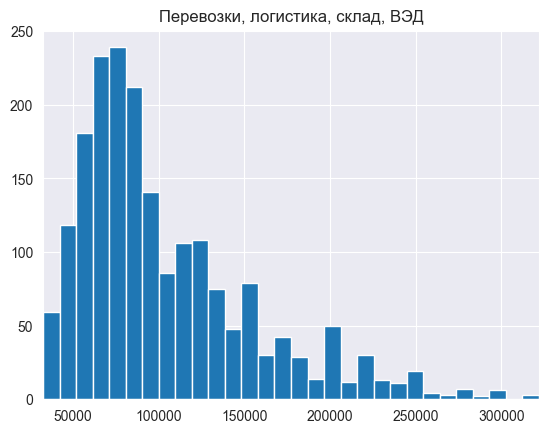

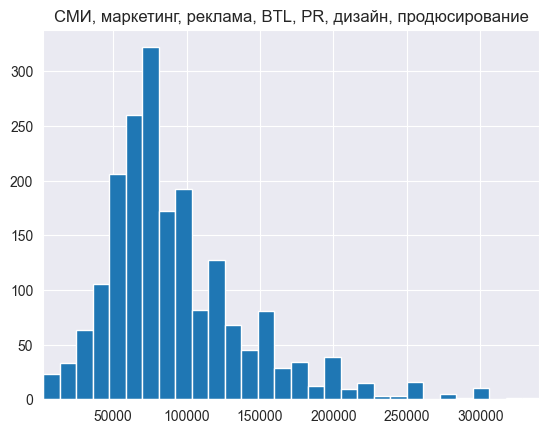

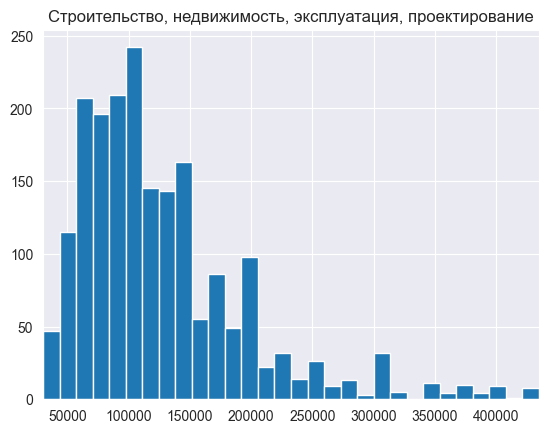

In [497]:
for dataset in dataset_without_outliers:
    plt.hist(dataset["salary"], 30)
    plt.title(dataset["industry"][0])
    plt.xlim((dataset["salary"].min(), dataset["salary"].max()))
    plt.show()

Видно что графики не похожи, можно проверить используя статистику 

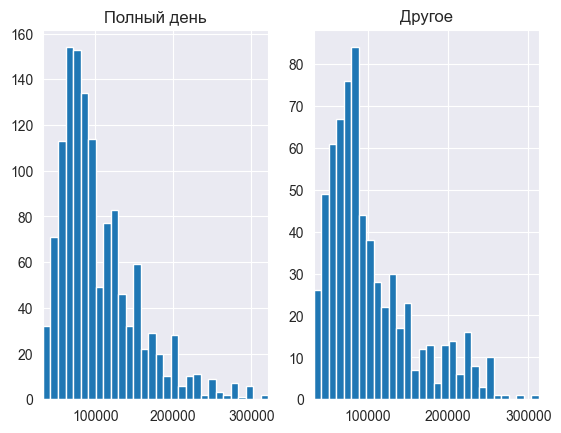

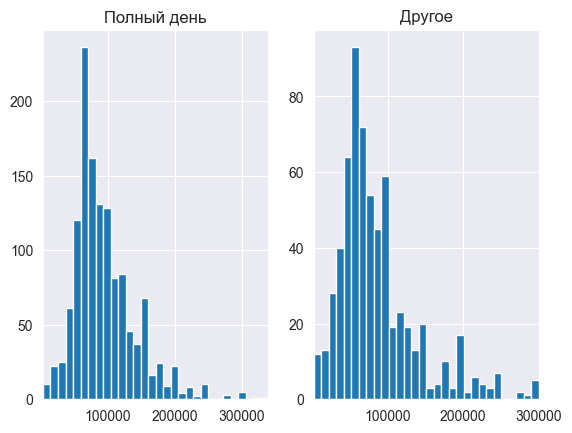

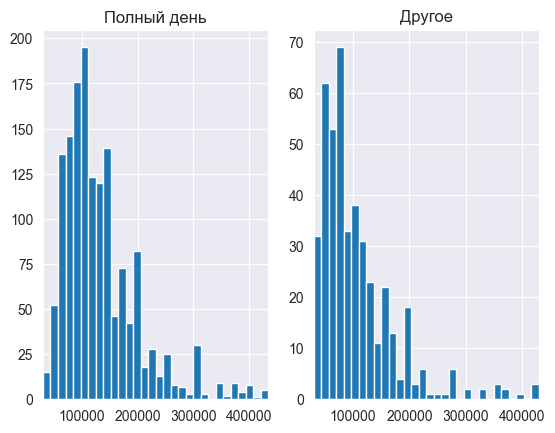

In [498]:
for dataset in dataset_without_outliers:
    in_office = dataset.loc[dataset["schedule"] == "Полный день", "salary"]
    out_office = dataset.loc[dataset["schedule"] != "Полный день", "salary"]
    ax, fig = plt.subplots(ncols=2)
    fig[0].hist(in_office, 30)
    fig[0].set_title("Полный день")
    fig[0].set_xlim((in_office.min(), in_office.max()))
    fig[1].hist(out_office, 30)
    fig[1].set_title("Другое")
    fig[1].set_xlim((out_office.min(), out_office.max()))
    plt.show()

По графикам не видно есть ли отличие между зарплатами тех, кто работает полный день в офисе и теми кто не делает так. Нужно проверить это на стадии гипотез

https://habr.com/ru/companies/ods/articles/338554/

Посмотрим на средние предлагаемые зарплаты по районам Москвы

In [499]:
import geopandas as gpd
%matplotlib inline
mo_gdf = gpd.read_file('src_files/atd/mo.shp')
mo_gdf.head()

,NAME,OKATO,OKTMO,NAME_AO,OKATO_AO,ABBREV_AO,TYPE_MO,geometry
0,Киевский,45298555,45945000,Троицкий,45298000,Троицкий,Поселение,"MULTIPOLYGON (((36.80310 55.44083, 36.80319 55..."
1,Филёвский Парк,45268595,45328000,Западный,45268000,ЗАО,Муниципальный округ,"POLYGON ((37.42765 55.74821, 37.42849 55.74875..."
2,Новофёдоровское,45298567,45954000,Троицкий,45298000,Троицкий,Поселение,"POLYGON ((36.80357 55.45162, 36.80451 55.46551..."
3,Роговское,45298575,45956000,Троицкий,45298000,Троицкий,Поселение,"POLYGON ((36.93724 55.24139, 36.93726 55.24161..."
4,"""Мосрентген""",45297568,45953000,Новомосковский,45297000,Новомосковский,Поселение,"POLYGON ((37.43956 55.62731, 37.44018 55.63042..."


In [500]:
mo_gdf.shape

(146, 8)

<Axes: >

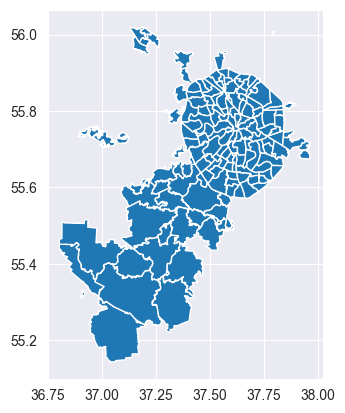

In [501]:
mo_gdf.plot()

C:\Users\danil\Desktop\lab02ML\venv\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<Axes: >

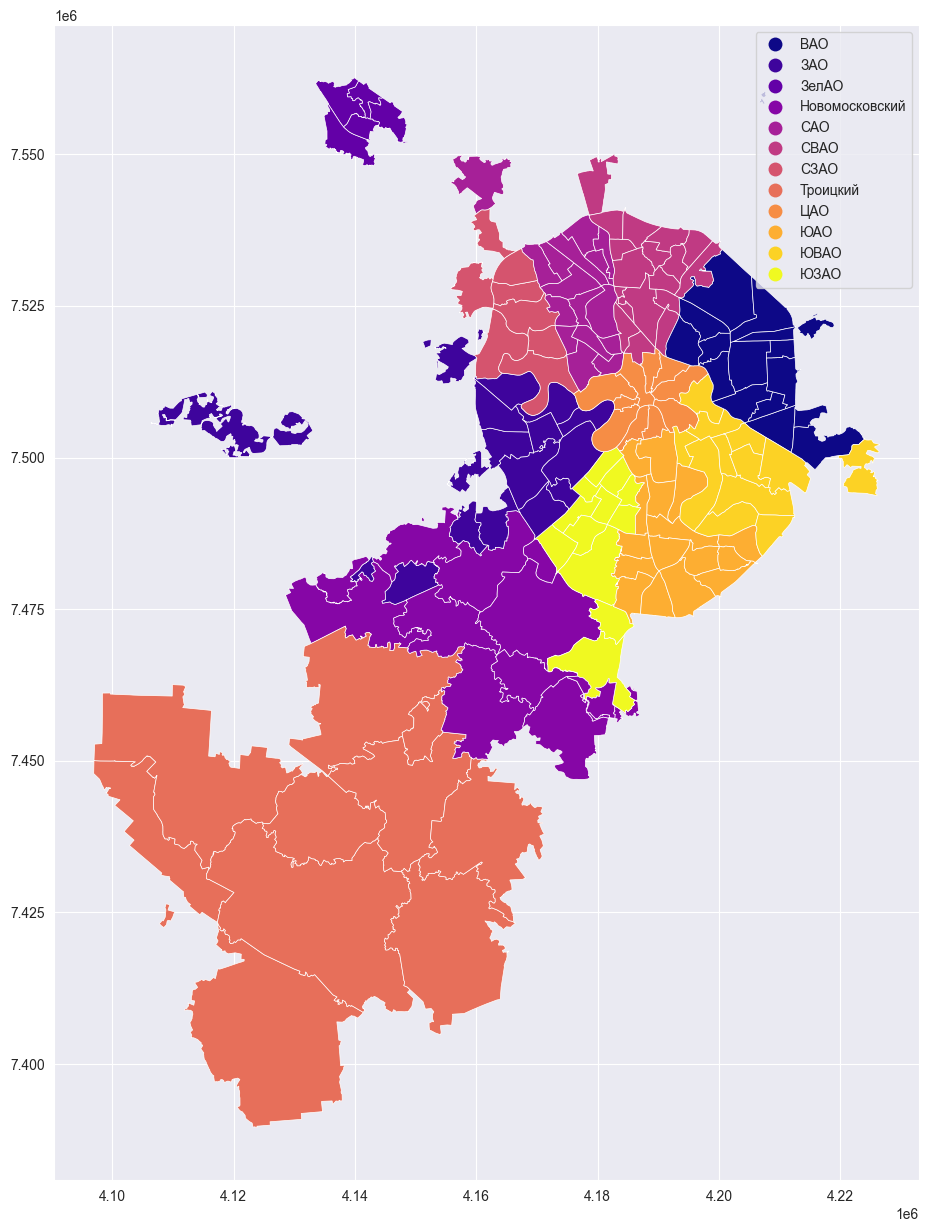

In [502]:
mo_gdf_wm = mo_gdf.to_crs({'init' :'epsg:3857'}) #непосредственно преобразование проекции
mo_gdf_wm.plot(column = 'ABBREV_AO', linewidth=0.5, cmap='plasma', legend=True, figsize=[15,15])

https://stackoverflow.com/questions/76089003/geopandas-checking-whether-point-is-inside-polygon

In [503]:
type(mo_gdf.iloc[0, -1])

shapely.geometry.multipolygon.MultiPolygon

In [504]:
from shapely.geometry import Point
from shapely.geometry.multipolygon import MultiPolygon
from shapely.geometry.polygon import Polygon
def within_a_polygon(lat, lon, polygon):
    point = Point(lon, lat)
    return polygon.contains(point)

def find_AO(lat_lon):
    lat, lon = lat_lon.loc["lat"], lat_lon.loc["lon"]
    for idx in mo_gdf.index:
        if within_a_polygon(lat, lon, mo_gdf.loc[idx, "geometry"]):
            return mo_gdf.loc[idx, "ABBREV_AO"]
    return "Не в Москве"
for dataset in dataset_without_outliers:
    dataset.loc[:,"AO"] = dataset[["lat", "lon"]].apply(find_AO, axis=1)

C:\Users\danil\AppData\Local\Temp\ipykernel_23680\1539276958.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.loc[:,"AO"] = dataset[["lat", "lon"]].apply(find_AO, axis=1)
C:\Users\danil\AppData\Local\Temp\ipykernel_23680\1539276958.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.loc[:,"AO"] = dataset[["lat", "lon"]].apply(find_AO, axis=1)
C:\Users\danil\AppData\Local\Temp\ipykernel_23680\1539276958.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

In [505]:
print(mo_gdf.loc[46, "ABBREV_AO"])

ЗАО


In [506]:
dataset_without_outliers[0].head()

,premium,has_test,response_letter_required,salary,trusted_employer,schedule,accept_temporary,accept_incomplete_resumes,experience,employment,is_adv_vacancy,industry,stations_nearby,distance_to_the_nearest,lat,lon,AO
0,False,False,False,100000.0,True,Полный день,False,True,От 3 до 6 лет,Полная занятость,False,"Перевозки, логистика, склад, ВЭД",0.0,inf,55.686548,37.466709,ЗАО
1,True,False,False,85000.0,True,Полный день,False,True,Нет опыта,Полная занятость,False,"Перевозки, логистика, склад, ВЭД",0.0,inf,55.574925,37.697576,Не в Москве
2,False,False,False,134850.0,True,Полный день,False,False,От 3 до 6 лет,Полная занятость,False,"Перевозки, логистика, склад, ВЭД",1.0,905.93753,55.716930,37.628882,ЮАО
3,False,False,False,104400.0,True,Сменный график,False,True,Нет опыта,Полная занятость,False,"Перевозки, логистика, склад, ВЭД",NaN,NaN,NaN,NaN,Не в Москве
4,False,False,False,127890.0,True,Полный день,False,True,От 1 года до 3 лет,Полная занятость,False,"Перевозки, логистика, склад, ВЭД",1.0,0.00000,55.777439,37.582107,ЦАО


In [507]:
dataset_without_outliers[0]["AO"].value_counts()

AO
Не в Москве       841
ЦАО               189
ЮАО               187
ЮВАО              152
САО               120
ЗАО               115
СВАО              105
ВАО                81
Новомосковский     63
ЮЗАО               62
СЗАО               41
ЗелАО               2
Троицкий            2
Name: count, dtype: int64

In [518]:
adm_okrugs_avg_salaries = {
"ЦАО": 0,
"ЮАО": 0,
"ЮВАО": 0,
"САО": 0,
"ЗАО": 0,
"СВАО": 0,
"ВАО": 0,
"Новомосковский": 0,
"ЮЗАО": 0,
"СЗАО": 0,
"ЗелАО": 0,
"Троицкий": 0,
"Не в Москве": 0
}

In [519]:
for ao in adm_okrugs_avg_salaries.keys():
    adm_okrugs_avg_salaries[ao] = dataset_without_outliers[0].loc[dataset_without_outliers[0]["AO"] == ao, "salary"].mean()

In [520]:
df_to_salary = mo_gdf[["ABBREV_AO", "geometry"]]
df_to_salary["avg_salary"] = df_to_salary["ABBREV_AO"].apply(lambda x: adm_okrugs_avg_salaries[x])

C:\Users\danil\Desktop\lab02ML\venv\Lib\site-packages\geopandas\geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,ABBREV_AO,geometry,avg_salary
0,Троицкий,"MULTIPOLYGON (((36.80310 55.44083, 36.80319 55...",107525.000000
1,ЗАО,"POLYGON ((37.42765 55.74821, 37.42849 55.74875...",102715.078087
2,Троицкий,"POLYGON ((36.80357 55.45162, 36.80451 55.46551...",107525.000000
3,Троицкий,"POLYGON ((36.93724 55.24139, 36.93726 55.24161...",107525.000000
4,Новомосковский,"POLYGON ((37.43956 55.62731, 37.44018 55.63042...",97210.772222


C:\Users\danil\Desktop\lab02ML\venv\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<Axes: >

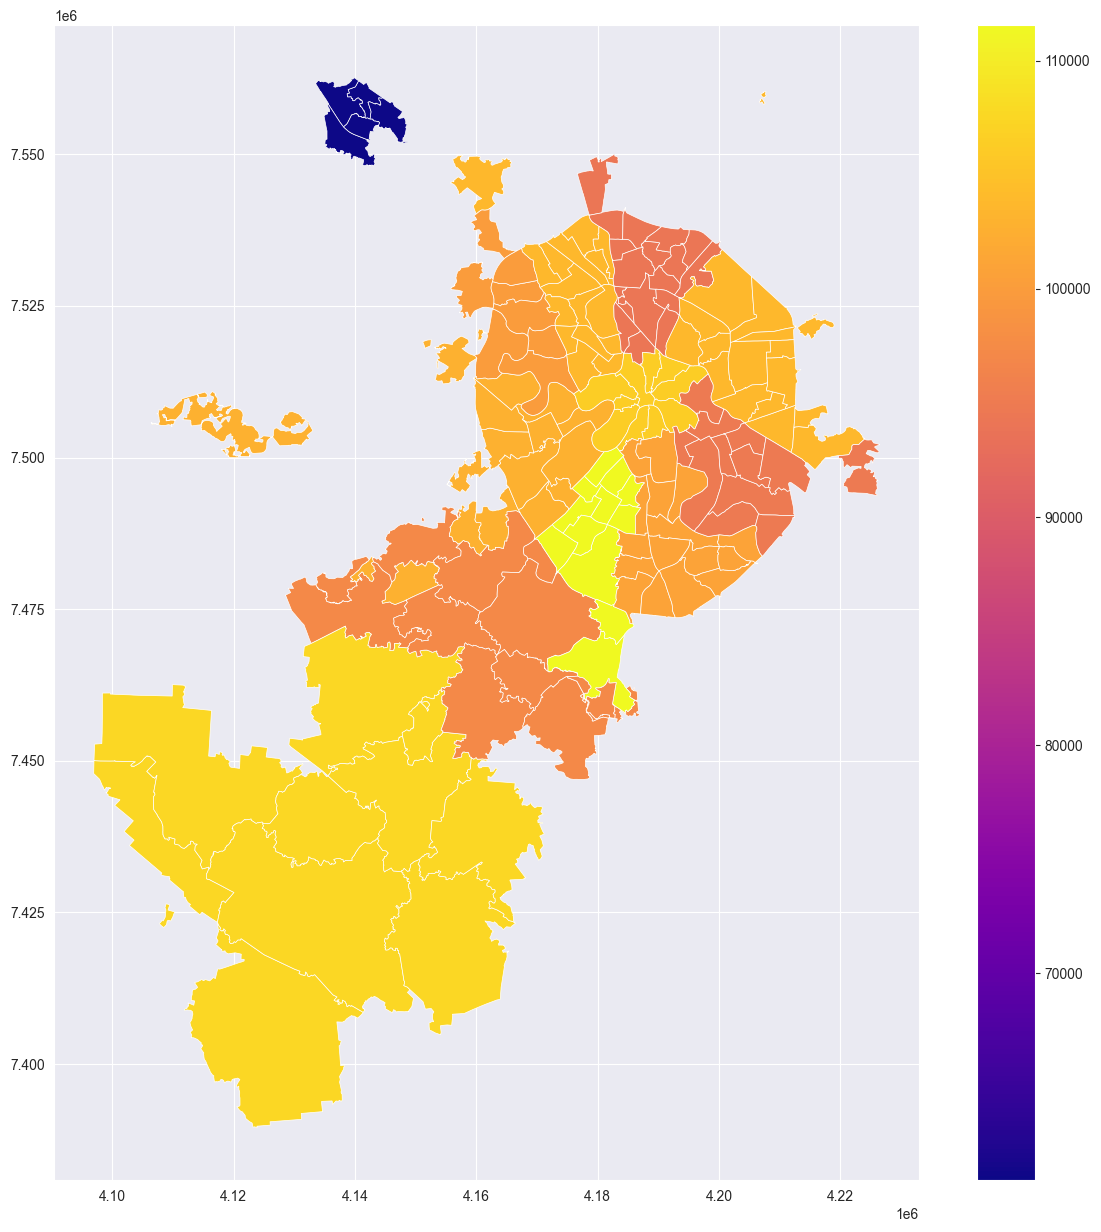

In [522]:
sals = df_to_salary.to_crs({'init' :'epsg:3857'}) #непосредственно преобразование проекции
sals.plot(column = 'avg_salary', linewidth=0.5, cmap='plasma', legend=True, figsize=[15,15])

C:\Users\danil\Desktop\lab02ML\venv\Lib\site-packages\geopandas\geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\danil\Desktop\lab02ML\venv\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


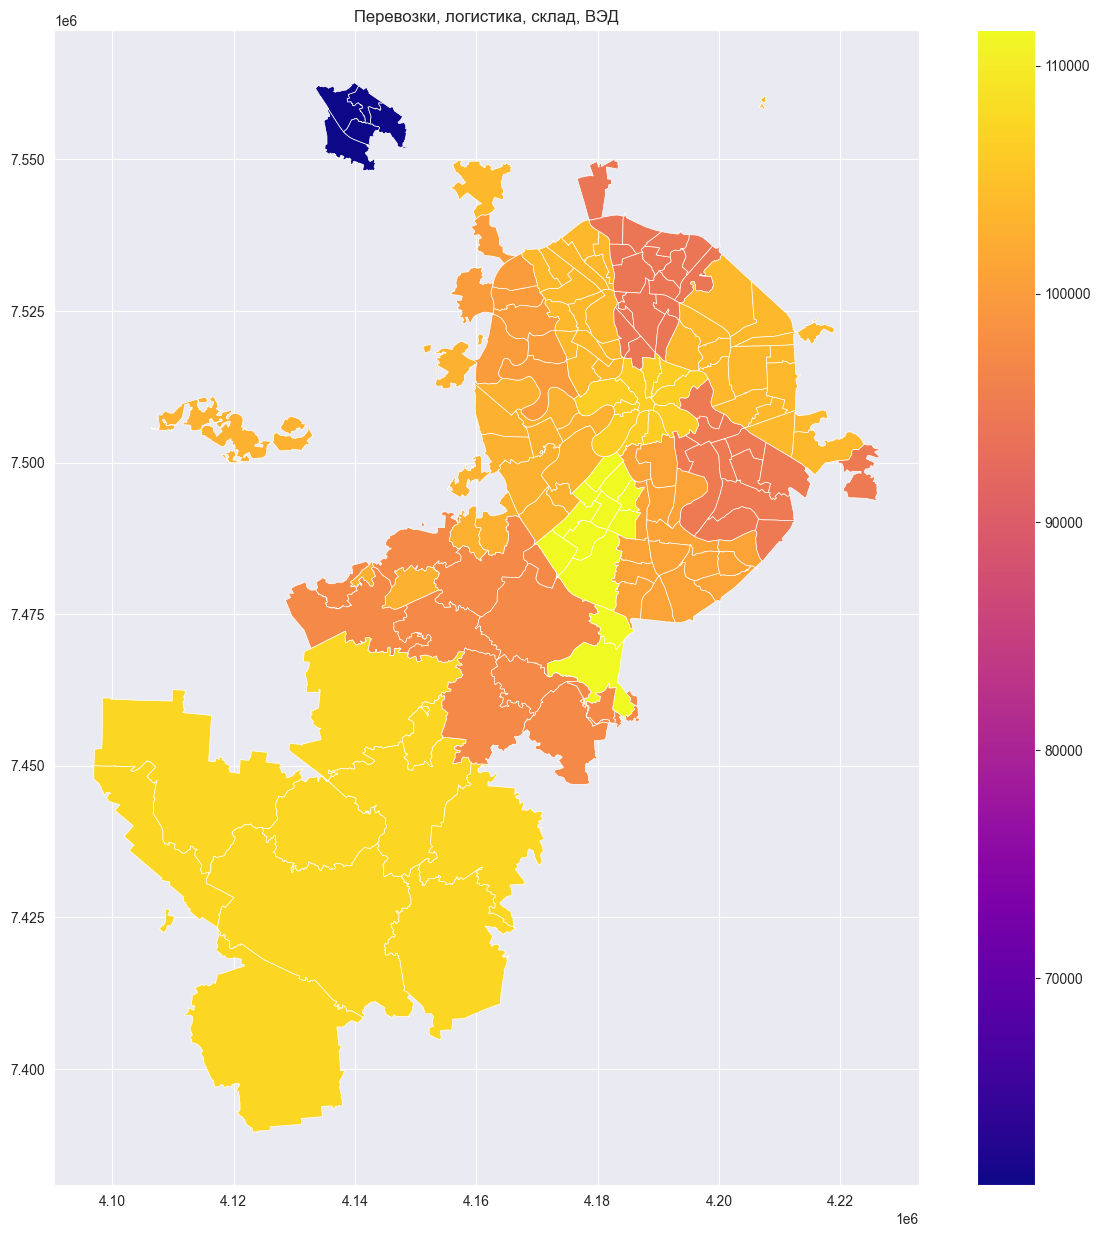

C:\Users\danil\Desktop\lab02ML\venv\Lib\site-packages\geopandas\geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\danil\Desktop\lab02ML\venv\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


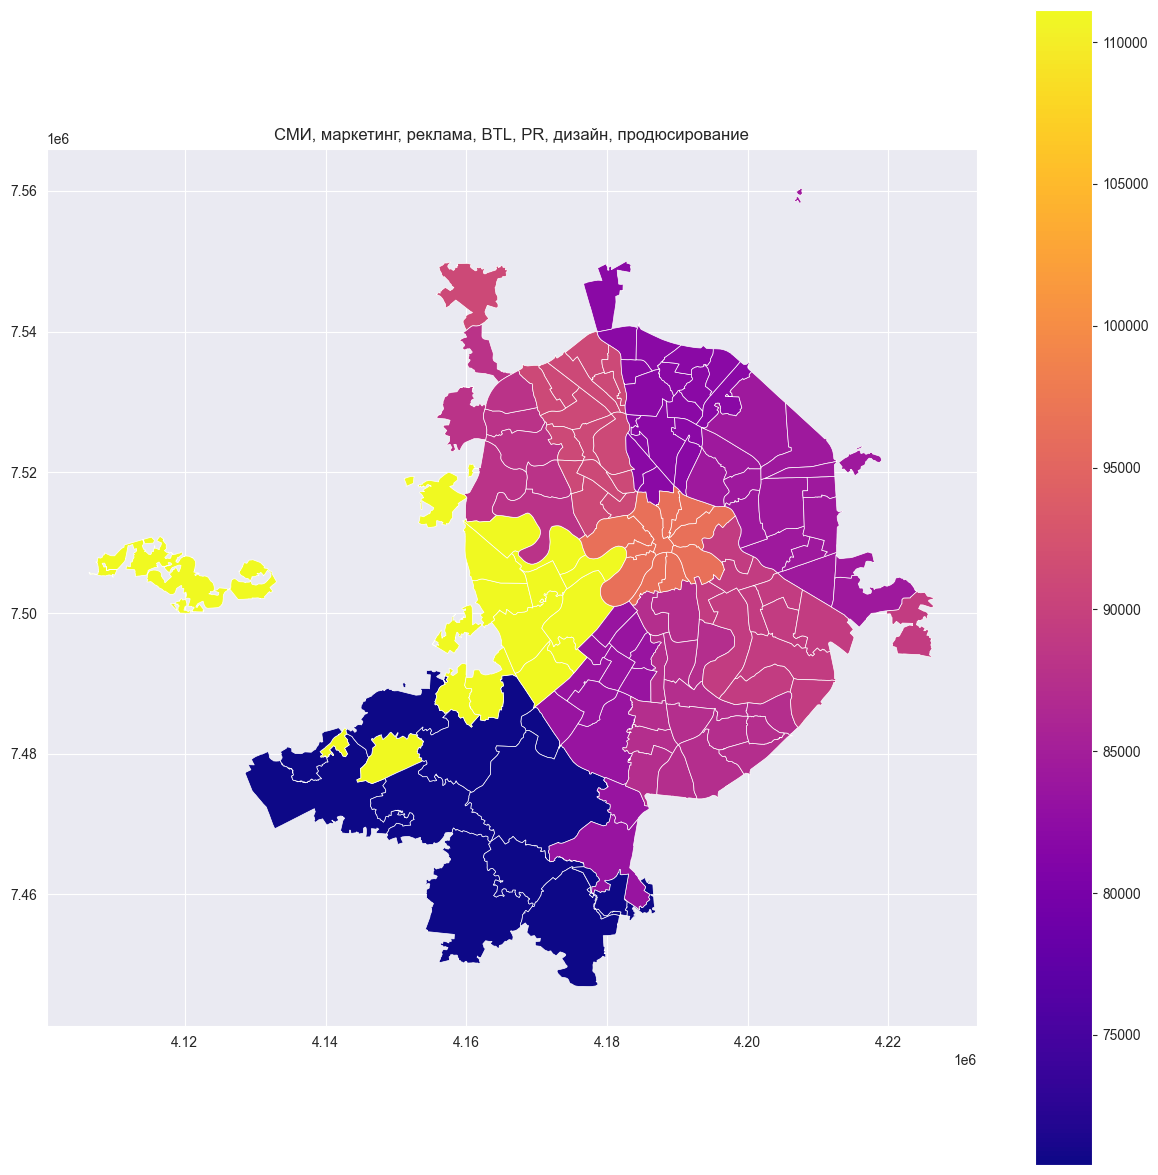

C:\Users\danil\Desktop\lab02ML\venv\Lib\site-packages\geopandas\geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\danil\Desktop\lab02ML\venv\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


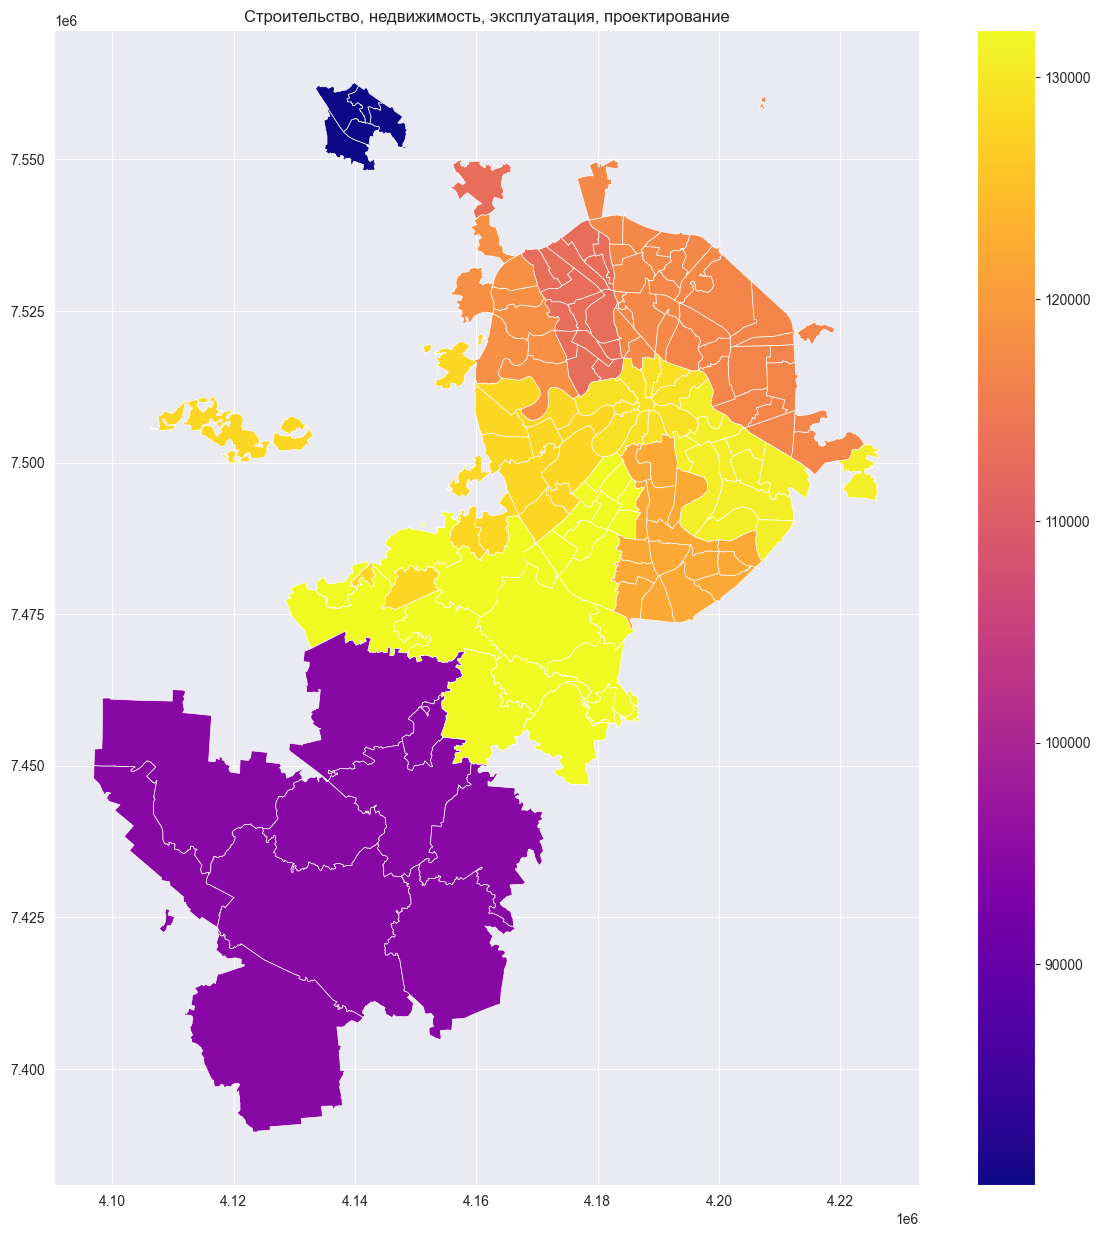

In [526]:
for dataset in dataset_without_outliers:
    adm_okrugs_avg_salaries = {
    "ЦАО": 0,
    "ЮАО": 0,
    "ЮВАО": 0,
    "САО": 0,
    "ЗАО": 0,
    "СВАО": 0,
    "ВАО": 0,
    "Новомосковский": 0,
    "ЮЗАО": 0,
    "СЗАО": 0,
    "ЗелАО": 0,
    "Троицкий": 0,
    "Не в Москве": 0
    }
    for ao in adm_okrugs_avg_salaries.keys():
        adm_okrugs_avg_salaries[ao] = dataset.loc[dataset["AO"] == ao, "salary"].mean()
    df_to_salary = mo_gdf[["ABBREV_AO", "geometry"]]
    df_to_salary["avg_salary"] = df_to_salary["ABBREV_AO"].apply(lambda x: adm_okrugs_avg_salaries[x])
    sals = df_to_salary.to_crs({'init' :'epsg:3857'}) #непосредственно преобразование проекции
    sals.plot(column = 'avg_salary', linewidth=0.5, cmap='plasma', legend=True, figsize=[15,15])
    plt.title(dataset["industry"][0])
    plt.show()

Очевидно что средняя предполагаемая зарплата зависит от округа и вида деятельности

In [527]:
adm_okrugs_avg_salaries["Не в Москве"]

133115.1273829201

На сколько похожи распределения зарплат внутри москвы и вне городских административных округов?

Организация: оставить только в пределах города Москвы, дальше весь анализ, графики и тд.